## This notebook takes the output of deepcell, processes it, segments cells, and outputs the extracted channel information

In [1]:
import numpy as np
import os
import skimage.io as io
import matplotlib.pyplot as plt
import sys

sys.path.append("../")

from segmentation.utils import data_utils, segmentation_utils
import xarray as xr

In [2]:
# set up filepaths
base_dir = '../data/example_dataset/'
base_name = "deepcell_output"
deepcell_dir = os.path.join(base_dir, base_name)

## The output of the deepcell network is first smoothed to avoid oversplitting

In [3]:
# define parameters for data extraction
# the amount of smoothing that will be applied to watershed image
pixel_smooth = [4, 6, 8]

In [4]:
# smooth the data using the thresholds specified above
pixel_xr_data = xr.open_dataarray(os.path.join(deepcell_dir, base_name + "_pixel.nc"))
pixel_xr_data.name = base_name + "_pixel"
data_utils.save_deepcell_tifs(pixel_xr_data, save_path=deepcell_dir,  transform='pixel', pixel_smooth=pixel_smooth)

processing point Point8


In [5]:
# load the processed deepcell output
pixel_xr = xr.open_dataarray(os.path.join(deepcell_dir, '{}_pixel_processed.nc'.format(base_name)))
input_xr = xr.open_dataarray(os.path.join(base_dir, "input_data/deepcell_input.nc"))

### We can then plot specific points, and look at the smoothing, to assess which is performing the best

In [7]:
# select point and smooth value to visualize
point = "Point8"
smooth = "pixel_interior_smoothed_6"

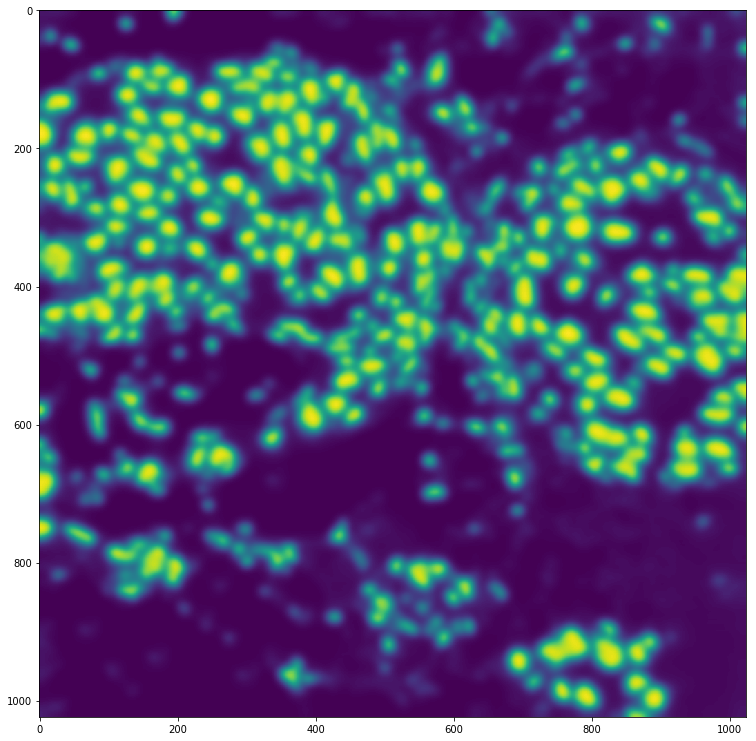

In [8]:
plt.figure(figsize = (13, 13))
plt.imshow(pixel_xr.loc[point, :, :, smooth])

### There are a few key tunable parameters for performing watershed

In [9]:
# this is the value that the deepcell probability mask is thresholded at to differentiate cell vs background.
# lower values will include more pixels, higher values less
background_threshold = 0.35

# this is the pixel smooth that was selected from above
pixel_smooth = 6

# these are the channels that will plotted to assess segmentation accuracy
overlay_channels = ["HH3", "Membrane"]

# if you're doing whole-cell prediction, set this to None. If you're doing nuclear prediction, set a single value
nuclear_expansion=None

### We then segment the data

In [10]:
segmentation_dir = base_dir + "/segmentation_output_threshold_{}_smooth_{}_expansion_{}/".format(background_threshold, pixel_smooth, nuclear_expansion)
if not os.path.isdir(segmentation_dir):
    os.makedirs(segmentation_dir)

In [10]:
# watershed over the processed deepcell output
segmentation_utils.watershed_transform(pixel_xr=pixel_xr, channel_xr=input_xr, 
                                       background_threshold=background_threshold,
                                       pixel_smooth="pixel_interior_smoothed_{}".format(pixel_smooth),
                                       overlay_channels=overlay_channels, output_dir=segmentation_dir, 
                                       rescale_factor=1.5, nuclear_expansion=nuclear_expansion)

analyzing point Point8


In [11]:
# load segmentation generated by watershed
segmentation_labels = xr.open_dataarray(os.path.join(segmentation_dir,
                                                     '{}_pixel_processed_segmentation_labels.nc'.format(base_name)))


### We can then visualize the segmented mask generated by the watershed

In [12]:
point = "Point8"

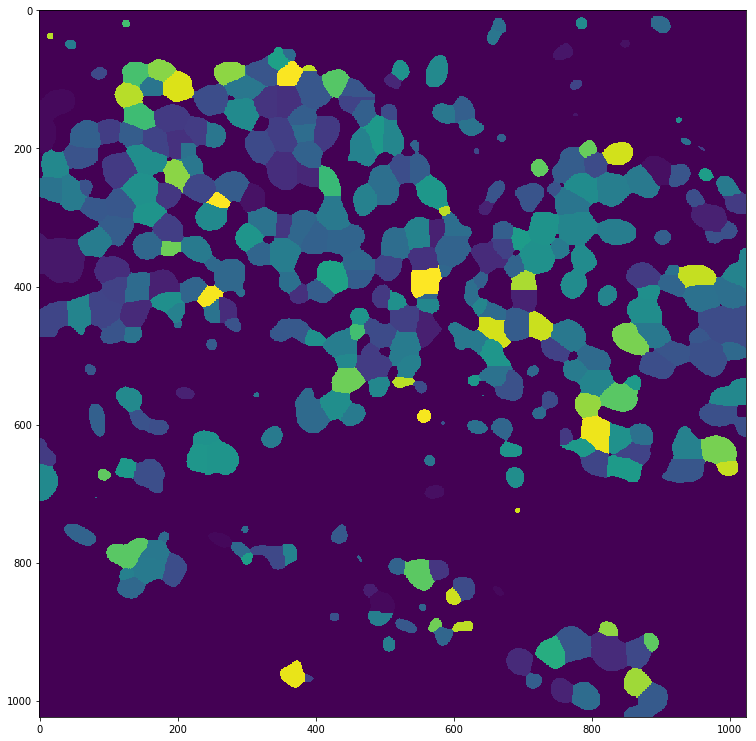

In [13]:
plt.figure(figsize = (13, 13))
plt.imshow(segmentation_labels.loc[point, :, :, "segmentation_label"])

### We can also visualize the segmented mask overlaid on the imaging data

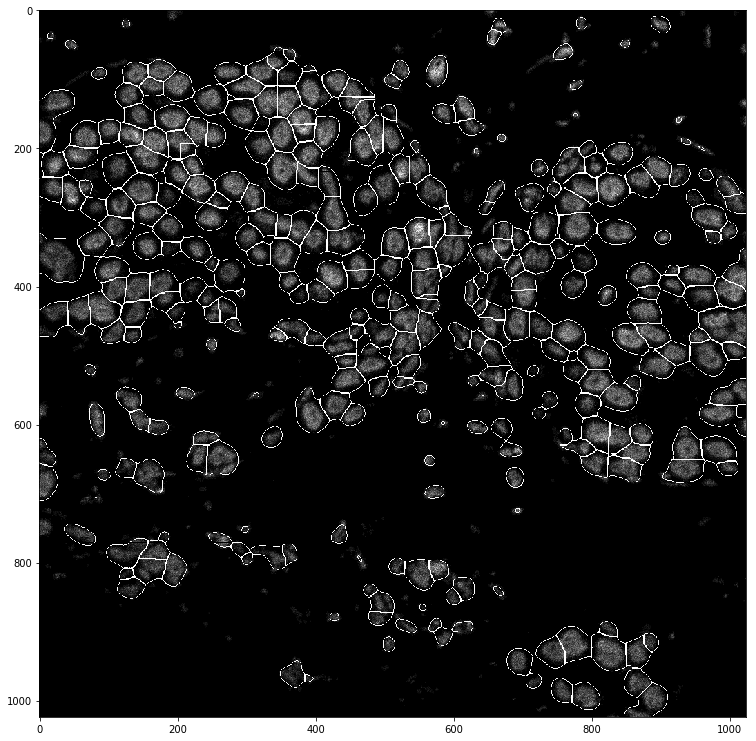

In [14]:
plt.figure(figsize = (13, 13))
plt.imshow(plt.imread(os.path.join(segmentation_dir, "Point8_HH3_overlay.tiff")))

### Once you're happy with the segmentation parameters, we extract the data

In [15]:
# load channel data
points_folder = os.path.join(base_dir, "Input_Data")
tif_folder = 'TIFs'
points = os.listdir(points_folder)
points = [point for point in points if os.path.isdir(os.path.join(points_folder, point))]
image_data = data_utils.load_tifs_from_points_dir(point_dir=points_folder, tif_folder=tif_folder, points=points)

In [16]:
single_cell_dir = base_dir + "single_cell_output_threshold_{}_smooth_{}_expansion_{}".format(background_threshold, pixel_smooth, nuclear_expansion)

if not os.path.exists(single_cell_dir):
    os.makedirs(single_cell_dir)

# segment the imaging data
segmentation_utils.extract_single_cell_data(segmentation_labels=segmentation_labels, image_data=image_data,
                                          save_dir=single_cell_dir)

# combine CSV files together
csv_files = os.listdir(single_cell_dir)
csv_files = [x for x in csv_files if 'transformed' in x]

segmentation_utils.concatenate_csv(base_dir=single_cell_dir, csv_files=csv_files)

extracting data from Point8
